# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [4]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

     |████████████████████████████████| 519.5MB 23kB/s 
ERROR: fastai 1.0.52 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 16.0MB 2.8MB/s 
     |████████████████████████████████| 5.4MB 2.8MB/s 


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [6]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [7]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [8]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [9]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADJ', '.', 'VERB', 'ADV', 'DET', 'ADP', 'CONJ', 'X', 'NUM', 'PRON', 'NOUN', 'PRT'}


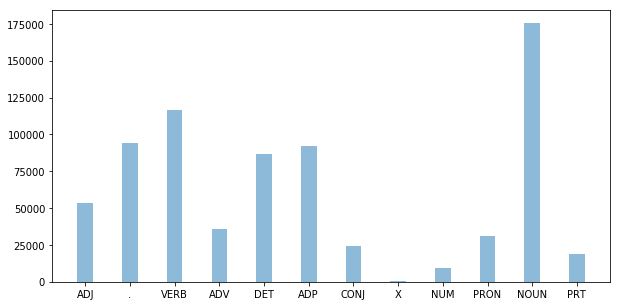

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [11]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [12]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [13]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [16]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        out, _ = self._lstm(emb)
        return self._out_layer(out)

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [18]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

preds = torch.argmax(logits, dim=-1)

mask = (y_batch != 0).float()
correct_count = ((preds == y_batch).float() * mask).sum().item()
total_count = mask.sum().item()

correct_count / total_count

Inputs:  torch.Size([32, 4])
Emb:  torch.Size([32, 4, 100])
Output of LSTM:  torch.Size([32, 4, 128])
Final output torch.Size([32, 4, 13])


0.043478260869565216

In [19]:
criterion = nn.CrossEntropyLoss()
criterion(logits.transpose(2, 1), y_batch)

tensor(2.5568, grad_fn=<NllLoss2DBackward>)

**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)

                mask = (y_batch != 0).float()
                cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
                cur_sum_count = mask.sum().item()
                
                # cur_correct_count, cur_sum_count = <calc accuracy>

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [24]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.31695, Accuracy = 72.10%: 100%|██████████| 572/572 [00:13<00:00, 41.02it/s]
[1 / 50]   Val: Loss = 0.10835, Accuracy = 84.37%: 100%|██████████| 13/13 [00:00<00:00, 37.60it/s]
[2 / 50] Train: Loss = 0.10138, Accuracy = 89.89%: 100%|██████████| 572/572 [00:13<00:00, 40.96it/s]
[2 / 50]   Val: Loss = 0.07997, Accuracy = 88.98%: 100%|██████████| 13/13 [00:00<00:00, 38.25it/s]
[3 / 50] Train: Loss = 0.06761, Accuracy = 93.25%: 100%|██████████| 572/572 [00:14<00:00, 40.76it/s]
[3 / 50]   Val: Loss = 0.07459, Accuracy = 90.74%: 100%|██████████| 13/13 [00:00<00:00, 39.54it/s]
[4 / 50] Train: Loss = 0.05123, Accuracy = 94.82%: 100%|██████████| 572/572 [00:13<00:00, 40.96it/s]
[4 / 50]   Val: Loss = 0.06969, Accuracy = 91.66%: 100%|██████████| 13/13 [00:00<00:00, 37.95it/s]
[5 / 50] Train: Loss = 0.04089, Accuracy = 95.83%: 100%|██████████| 572/572 [00:13<00:00, 43.91it/s]
[5 / 50]   Val: Loss = 0.07180, Accuracy = 92.24%: 100%|██████████| 13/13 [00:00<00:00, 39.46it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [27]:
correct_count = 0
sum_count = 0

for X_batch, y_batch in iterate_batches((X_test, y_test), 64):
    X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X_batch)

    preds = torch.argmax(logits, dim=-1)

    mask = (y_batch != 0).float()
    cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
    cur_sum_count = mask.sum().item()
                
    correct_count += cur_correct_count
    sum_count += cur_sum_count

correct_count / sum_count

0.9251520816334962

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        out, _ = self._lstm(emb)
        return self._out_layer(out)

In [37]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.25903, Accuracy = 76.22%: 100%|██████████| 572/572 [00:16<00:00, 35.85it/s]
[1 / 50]   Val: Loss = 0.06658, Accuracy = 89.28%: 100%|██████████| 13/13 [00:00<00:00, 28.25it/s]
[2 / 50] Train: Loss = 0.07750, Accuracy = 92.49%: 100%|██████████| 572/572 [00:16<00:00, 34.72it/s]
[2 / 50]   Val: Loss = 0.04438, Accuracy = 93.43%: 100%|██████████| 13/13 [00:00<00:00, 28.83it/s]
[3 / 50] Train: Loss = 0.04960, Accuracy = 95.33%: 100%|██████████| 572/572 [00:16<00:00, 34.83it/s]
[3 / 50]   Val: Loss = 0.03848, Accuracy = 94.86%: 100%|██████████| 13/13 [00:00<00:00, 28.98it/s]
[4 / 50] Train: Loss = 0.03505, Accuracy = 96.73%: 100%|██████████| 572/572 [00:16<00:00, 34.85it/s]
[4 / 50]   Val: Loss = 0.03377, Accuracy = 95.57%: 100%|██████████| 13/13 [00:00<00:00, 30.08it/s]
[5 / 50] Train: Loss = 0.02553, Accuracy = 97.64%: 100%|██████████| 572/572 [00:16<00:00, 34.77it/s]
[5 / 50]   Val: Loss = 0.03106, Accuracy = 95.85%: 100%|██████████| 13/13 [00:00<00:00, 29.32it/s]


In [38]:
correct_count = 0
sum_count = 0

for X_batch, y_batch in iterate_batches((X_test, y_test), 64):
    X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X_batch)

    preds = torch.argmax(logits, dim=-1)

    mask = (y_batch != 0).float()
    cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
    cur_sum_count = mask.sum().item()
                
    correct_count += cur_correct_count
    sum_count += cur_sum_count

correct_count / sum_count

0.9617721684585963

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [28]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [29]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding.from_pretrained(embeddings)
        self._lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, num_layers=lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        out, _ = self._lstm(emb)
        return self._out_layer(out)

In [39]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=torch.FloatTensor(embeddings),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.76232, Accuracy = 77.55%: 100%|██████████| 572/572 [00:10<00:00, 54.98it/s]
[1 / 50]   Val: Loss = 0.37226, Accuracy = 89.13%: 100%|██████████| 13/13 [00:00<00:00, 36.21it/s]
[2 / 50] Train: Loss = 0.28133, Accuracy = 91.61%: 100%|██████████| 572/572 [00:10<00:00, 54.04it/s]
[2 / 50]   Val: Loss = 0.25225, Accuracy = 92.29%: 100%|██████████| 13/13 [00:00<00:00, 39.63it/s]
[3 / 50] Train: Loss = 0.20456, Accuracy = 93.65%: 100%|██████████| 572/572 [00:11<00:00, 49.12it/s]
[3 / 50]   Val: Loss = 0.20851, Accuracy = 93.41%: 100%|██████████| 13/13 [00:00<00:00, 28.22it/s]
[4 / 50] Train: Loss = 0.16933, Accuracy = 94.62%: 100%|██████████| 572/572 [00:11<00:00, 54.50it/s]
[4 / 50]   Val: Loss = 0.18363, Accuracy = 94.14%: 100%|██████████| 13/13 [00:00<00:00, 38.45it/s]
[5 / 50] Train: Loss = 0.14942, Accuracy = 95.15%: 100%|██████████| 572/572 [00:10<00:00, 51.05it/s]
[5 / 50]   Val: Loss = 0.16823, Accuracy = 94.46%: 100%|██████████| 13/13 [00:00<00:00, 37.44it/s]


**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [42]:
correct_count = 0
sum_count = 0

for X_batch, y_batch in iterate_batches((X_test, y_test), 64):
    X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X_batch)

    preds = torch.argmax(logits, dim=-1)

    mask = (y_batch != 0).float()
    cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
    cur_sum_count = mask.sum().item()
                
    correct_count += cur_correct_count
    sum_count += cur_sum_count

correct_count / sum_count

0.9532549084411762